Alex Gagliano, 05/10/2020

Let's start by importing our required packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from astropy.time import Time
from collections import Counter
import glob
import os 

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")

In [2]:
#data = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_wSynthetic_rBand.csv")
#data = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_wSynthetic_wForcedZTF_final.csv")
data = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_final.csv")

#data = data[data['MJD']!=58856.452164351846]
#data.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry.csv",index=False)
#data = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_dropYSE.csv")

#data = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_clean_wUVOT.csv")

In [3]:
#SDSS filters and AB mags:
#These effective wavelengths for SDSS filters are from Fukugita et al. (1996, AJ, 111, 1748) and are
#the wavelength weighted averages (effective wavelengths in their Table 2a, first row)

#Effective wavelengths (in Angs)
wle = {'u': 3560,  'g': 4830, 'r': 6260, 'i': 7670, 'z': 8890, 'y': 9600, 'Y': 9600,
       'U': 3600,  'B': 4380, 'V': 5450, 'R': 6410, 'G': 6730, 'I': 7980, 'J': 12200, 'H': 16300,
       'K': 21900, 'UVW2': 2030, 'UVM2': 2231, 'UVW1': 2634, 'F': 1516, 'N': 2267, 'o': 6790, 'c': 5330}
extco = {'u': 4.786,  'g': 3.587, 'r': 2.471, 'i': 1.798,  'z': 1.403, 'y': 1.228, 'Y': 1.228,
         'U': 4.744,  'B': 4.016, 'V': 3.011, 'R': 2.386, 'G': 2.216, 'I': 1.684, 'J': 0.813, 'H': 0.516,
         'K': 0.337, 'UVW2': 8.795, 'UVM2': 9.270, 'UVW1': 6.432,  'F': 8.054,  'N': 8.969, 'o': 2.185, 'c': 3.111}
#All values in 1e-11 erg/s/cm2/Angs
zp = {'u': 859.5, 'g': 466.9, 'r': 278.0, 'i': 185.2, 'z': 137.8, 'y': 118.2, 'Y': 118.2,
      'U': 417.5, 'B': 632.0, 'V': 363.1, 'R': 217.7, 'G': 240.0, 'I': 112.6, 'J': 31.47, 'H': 11.38,
      'K': 3.961, 'UVW2': 536.2, 'UVM2': 463.7, 'UVW1': 412.3, 'F': 4801., 'N': 2119., 'o': 236.2, 'c': 383.3}
# For Swift UVOT: S=UVW2, D=UVM2, A=UVW1

In [4]:
data.loc[data['FLT']=='g-ZTF', 'FLT'] = 'g'
data.loc[data['FLT']=='r-ZTF', 'FLT'] = 'r'
data.loc[data['FLT']=='i-ZTF', 'FLT'] = 'i'
data.loc[data['FLT']=='up', 'FLT'] = 'u'
data.loc[data['FLT']=='gp', 'FLT'] = 'g'
data.loc[data['FLT']=='rp', 'FLT'] = 'r'
data.loc[data['FLT']=='ip', 'FLT'] = 'i'

data = data[data['FLT'] != 'orange']

In [5]:
bands =np.unique(data['FLT'])
#ebv = 0.028
#ebv_err = 0.028
#ebv = 0.173
ebv = 0.133
ebv_err = 0.03

data_corr = []
for band in bands:
    temp = data[data['FLT']==band]
    tempCorr = extco[band]
    temp['MAG'] -= tempCorr*ebv
    temp['MAGERR'] = np.sqrt(temp['MAGERR']**2 + ebv_err**2) #propagate extinction uncertainty
    data_corr.append(temp)

data_corr_DF = pd.concat(data_corr, ignore_index=True)

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


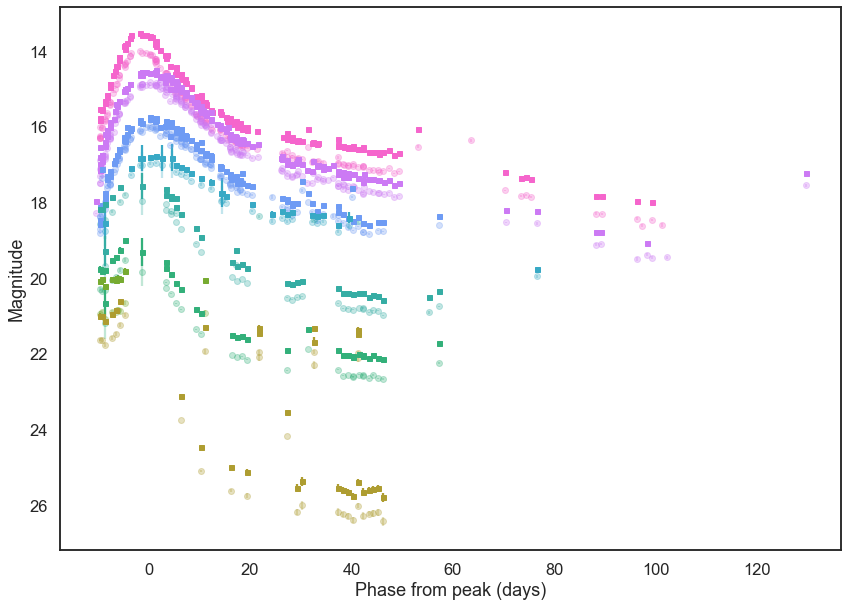

In [6]:
data_plt = data

colors = sns.husl_palette(10)
colors.reverse()
plt.figure(figsize=(14, 10))
bands = [['g', 'g-ZTF', 'gp'],['r', 'r-ZTF', 'rp'],['i', 'i-ZTF', 'ip'],['z', 'z-ZTF', 'zp'], ['V'], ['B'], ['UVW1'], ['U','u', 'up']]

j = 0
clean_data = []
for i in np.arange(len(bands)):
    band = bands[i]
    tmp = data_plt[data_plt['FLT'].isin(band)]
    if band == ['U','u', 'up']:
        tmp = tmp[tmp['TELESCOPE'].isin(['Swope', 'Swift'])]
        tmp_early = tmp[(tmp['MJD']-58866) < 0]
        tmp_late = tmp[(tmp['MJD']-58866) > 0]
        tmp_late = tmp_late[tmp_late['MAGERR'] < 0.5]
        tmp = pd.concat([tmp_early, tmp_late],ignore_index=True)
    elif band == ['UVW1']:
        tmp = tmp[tmp['MAGERR'] < 1.]
        tmp = tmp[tmp['MJD']-58866 < 20.]
    else:
        if (band == ['z', 'z-ZTF', 'zp']):
            tmp = tmp[tmp['MAGERR'] < 0.5]
        elif (band == ['B']) | (band ==['V']):
            tmp_early = tmp[(tmp['MJD']-58866) < 0]
            tmp_late = tmp[(tmp['MJD']-58866) > 0]
            tmp_late = tmp_late[tmp_late['MAGERR'] < 0.05]
            tmp = pd.concat([tmp_early, tmp_late],ignore_index=True)
        else:
            tmp = tmp[tmp['MAGERR'] < 0.05]
    tmp = tmp[tmp['MAG'] > 13.5]
    if(len(tmp)) > 2:
        clean_data.append(tmp)
        plt.errorbar(tmp['MJD']-58866.0, tmp['MAG']+i, tmp['MAGERR'], fmt='o', c=colors[i], label=band,ms=6, alpha=0.3)

data_plt = data_corr_DF

j = 0
clean_data = []
for i in np.arange(len(bands)):
    band = bands[i]
    tmp = data_plt[data_plt['FLT'].isin(band)]
    if band == ['U','u', 'up']:
        tmp = tmp[tmp['TELESCOPE'].isin(['Swope', 'Swift'])]
        tmp_early = tmp[(tmp['MJD']-58866) < 0]
        tmp_late = tmp[(tmp['MJD']-58866) > 0]
        tmp_late = tmp_late[tmp_late['MAGERR'] < 0.5]
        tmp = pd.concat([tmp_early, tmp_late],ignore_index=True)
    elif band == ['UVW1']:
        tmp = tmp[tmp['MAGERR'] < 1.]
        tmp = tmp[tmp['MJD']-58866 < 20.]
    else:
        if (band == ['z', 'z-ZTF', 'zp']):
            tmp = tmp[tmp['MAGERR'] < 0.5]
        elif (band == ['B']) | (band ==['V']):
            tmp_early = tmp[(tmp['MJD']-58866) < 0]
            tmp_late = tmp[(tmp['MJD']-58866) > 0]
            tmp_late = tmp_late[tmp_late['MAGERR'] < 0.05]
            tmp = pd.concat([tmp_early, tmp_late],ignore_index=True)
        else:
            tmp = tmp[tmp['MAGERR'] < 0.05]
    tmp = tmp[tmp['MAG'] > 13.5]
    if(len(tmp)) > 2:
        clean_data.append(tmp)
        plt.errorbar(tmp['MJD']-58866.0, tmp['MAG']+i, tmp['MAGERR'], fmt='s', c=colors[i], label=band,ms=5)

#plt.legend(fontsize=14)
plt.gca().invert_yaxis()
#plt.xlim((-15, 60))
plt.xlabel("Phase from peak (days)")
plt.ylabel("Magnitude")
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/2020oi_TotalExtinctionCorrection_AllData.png", bbox_inches='tight', dpi=300)

In [7]:
data_corr_DF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oi_finalPhotometry_0133ExtCorr.csv",index=False)

In [22]:
#now do the same for the spectra
floyds_Jan20 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-20.csv")
floyds_Jan22 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-22.csv")
floyds_Jan24 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-24.csv")
lris_Jan27 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/SN2020oi-20200127-lris.flm", delim_whitespace=True, header=None, names=['wavelength', 'flux'])
floyds_Jan28 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-S-2020-01-28.csv")
floyds_Jan31 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-31.csv")
floyds_Feb01 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-02-01.csv")

In [23]:
floyds_Jan20

wavelength      flux  fluxerr
0       3201.227  173391.0    -99.0
1       3202.969  146821.0    -99.0
2       3204.711  163941.0    -99.0
3       3206.454  131070.0    -99.0
4       3208.196  148691.0    -99.0
...          ...       ...      ...
4185   10492.327   72101.9    -99.0
4186   10494.069   81825.5    -99.0
4187   10495.811  135997.0    -99.0
4188   10497.553  206834.0    -99.0
4189   10499.295  188285.0    -99.0

[4190 rows x 3 columns]

In [25]:
from extinction import ccm89, apply, remove

# "deredden" flux for galactic extinction
newfloyds_Jan20_flux = remove(ccm89(floyds_Jan20['wavelength'].values, 3.1*ebv, 3.1), floyds_Jan20['flux'].values)
newfloyds_Jan22_flux = remove(ccm89(floyds_Jan22['wavelength'].values, 3.1*ebv, 3.1), floyds_Jan22['flux'].values)
newfloyds_Jan24_flux = remove(ccm89(floyds_Jan24['wavelength'].values, 3.1*ebv, 3.1), floyds_Jan24['flux'].values)
newlris_Jan27_flux = remove(ccm89(lris_Jan27['wavelength'].values, 3.1*ebv, 3.1), lris_Jan27['flux'].values)
newfloyds_Jan28_flux = remove(ccm89(floyds_Jan28['wavelength'].values, 3.1*ebv, 3.1), floyds_Jan28['flux'].values)
newfloyds_Jan31_flux = remove(ccm89(floyds_Jan31['wavelength'].values, 3.1*ebv, 3.1), floyds_Jan31['flux'].values)
newfloyds_Feb01_flux = remove(ccm89(floyds_Feb01['wavelength'].values, 3.1*ebv, 3.1), floyds_Feb01['flux'].values)

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/Users/alexgagliano/miniconda3/lib/pyt

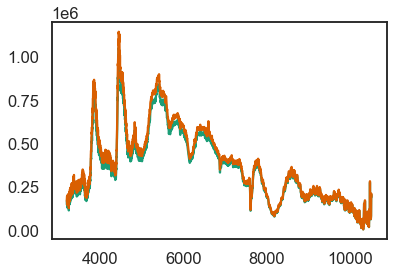

In [26]:
#AV/EBV = RV
#RV * EBV = AV
plt.plot(floyds_Jan20['wavelength'], floyds_Jan20['flux'])
plt.plot(floyds_Jan20['wavelength'], newfloyds_Jan20_flux)

In [28]:
newfloyds_Jan20 = pd.DataFrame({'wavelength':floyds_Jan20['wavelength'].values, 'flux':newfloyds_Jan20_flux})
newfloyds_Jan22 = pd.DataFrame({'wavelength':floyds_Jan22['wavelength'].values, 'flux':newfloyds_Jan22_flux})
newfloyds_Jan24 = pd.DataFrame({'wavelength':floyds_Jan24['wavelength'].values, 'flux':newfloyds_Jan24_flux})
newlris_Jan27 = pd.DataFrame({'wavelength':lris_Jan27['wavelength'].values, 'flux':newlris_Jan27_flux})
newfloyds_Jan28_flux = pd.DataFrame({'wavelength':floyds_Jan28['wavelength'].values, 'flux':newfloyds_Jan28_flux})
newfloyds_Jan31_flux = pd.DataFrame({'wavelength':floyds_Jan31['wavelength'].values, 'flux':newfloyds_Jan31_flux})
newfloyds_Feb01_flux = pd.DataFrame({'wavelength':floyds_Feb01['wavelength'].values, 'flux':newfloyds_Feb01_flux})

In [29]:
newfloyds_Jan20.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-20_GalExtCor.csv",index=False)
newfloyds_Jan22.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-22_GalExtCor.csv",index=False)
newfloyds_Jan24.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-24_GalExtCor.csv",index=False)
newlris_Jan27.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-lris-2020-01-27_GalExtCor.csv",index=False)
newfloyds_Jan28_flux.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-S-2020-01-28_GalExtCor.csv",index=False)
newfloyds_Jan31_flux.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-31_GalExtCor.csv",index=False)
newfloyds_Feb01_flux.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-02-01_GalExtCor.csv",index=False)